In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.cluster import KMeansClusterer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import json
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pyLDAvis
import pyLDAvis.sklearn
import math
import copy
from wordcloud import WordCloud
import scipy
%matplotlib inline

# 1. Read articles from text file

In [2]:
articles = None
filename = 'trade_war_new.txt'
folder_name = 'Master_dataset'
with open(folder_name + '/' + filename) as json_file:  
    articles = json.load(json_file)
df = pd.DataFrame(articles)
df

,authors,body,dataType,date,dateTime,eventUri,image,isDuplicate,lang,sentiment,sim,source,time,title,uri,url,wgt
0,"[{'uri': 'patricia_cohen@nytimes.com', 'name':...","OSSEO, Wis. -- From the start, President Trump...",news,2019-05-24,2019-05-24T09:10:00Z,eng-4811504,https://static01.nyt.com/images/2019/05/22/aut...,False,eng,0.137255,0.654902,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",09:10:00,'How Long Is Short-Term?' Pain of Tariffs Test...,1144357745,https://www.nytimes.com/2019/05/24/business/ec...,296385000
1,[],Good Friday morning. Here are some of the stor...,news,2019-05-24,2019-05-24T04:22:00Z,None,https://static01.nyt.com/newsgraphics/images/i...,False,eng,-0.113725,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",04:22:00,On Politics: The Trade War Is Here to Stay,1144187790,https://www.nytimes.com/2019/05/24/us/politics...,296367720
2,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The United States and China are ...,news,2019-05-23,2019-05-23T17:39:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.200000,0.560784,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",17:39:00,Trump Gives Farmers $16 Billion in Aid Amid Pr...,1143836481,https://www.nytimes.com/2019/05/23/us/politics...,296329140
3,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The Trump administration is prep...,news,2019-05-23,2019-05-23T12:19:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.349020,0.533333,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",12:19:00,Trump Administration to Announce Farm Aid to E...,1143567051,https://www.nytimes.com/2019/05/23/us/politics...,296309940
4,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump agreed on Friday...,news,2019-05-22,2019-05-22T15:42:00Z,None,https://static01.nyt.com/images/2019/05/17/us/...,False,eng,0.074510,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",15:42:00,Trump Lifts Metal Tariffs and Delays Auto Levi...,1142795786,https://www.nytimes.com/2019/05/17/us/politics...,296235720
5,"[{'uri': 'alexandra_stevenson@nytimes.com', 'n...",BEIJING -- President Xi Jinping of China has c...,news,2019-05-22,2019-05-22T03:15:00Z,eng-4801161,https://static01.nyt.com/images/2019/05/22/wor...,False,eng,-0.105882,0.498039,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",03:15:00,China Faces New 'Long March' as Trade War Inte...,1141957321,https://www.nytimes.com/2019/05/21/world/asia/...,296190900
6,"[{'uri': 'keith_bradsher@nytimes.com', 'name':...","A week ago, the United States and China looked...",news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/wor...,False,eng,-0.129412,0.780392,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Could Raise Tariffs on China. Here's How...,1141791853,https://www.nytimes.com/2019/05/09/business/tr...,296169600
7,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump escalated his tr...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/bus...,False,eng,-0.090196,0.635294,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Increases China Tariffs as Trade Deal Ha...,1141791852,https://www.nytimes.com/2019/05/09/us/politics...,296169600
8,"[{'uri': 'raymond_zhong@nytimes.com', 'name': ...",BEIJING -- When the United States ratcheted up...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/10/wor...,False,eng,-0.082353,0.552941,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,"China, Defiant but Careful, Promises Aggressiv...",1141791849,https://www.nytimes.com/2019/05/10/business/ch...,296169600
9,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- A yearlong trade war between the...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/12/us/...,False,eng,0.176471,0.470

# 2. Text processing

In [3]:
lemmatizer = WordNetLemmatizer()
pattern = re.compile('^[$€]?[0-9]+(,[0-9]+)*.?[0-9]*[,.]?$')

def matchesNum(term):
    if re.match(pattern, term):
        return(True)
    else:
        return(False)

def removePunctuation(term):
    return term.translate(str.maketrans('', '', string.punctuation))

def updateNumbers(text):
    split_text = text.split(' ')
    updated_split_text=[]
    term_num=len(split_text)
    i = 0
    while i < term_num:
        if matchesNum(split_text[i]):
        
            if (i+1 < term_num) and (removePunctuation(split_text[i+1])=='million' or removePunctuation(split_text[i+1])=='billion'):
                new_word = split_text[i].translate(str.maketrans('', '', ','))+removePunctuation(split_text[i+1])
                i+=1
            else:
                new_word = split_text[i].translate(str.maketrans('', '', ','))
            new_word = new_word.rstrip('.')
            new_word = new_word.replace('.','dot')
            new_word = new_word.replace('$','dol')
            new_word = new_word.replace('€','eur')
            updated_split_text.append(new_word)
        else:
            updated_split_text.append(split_text[i])
        i+=1
    return ' '.join(updated_split_text)

def process_text(text):
    updated_text = updateNumbers(text)
    words = nltk.word_tokenize(updated_text)
    words = [w.lower() for w in words]
    words = [w.translate(str.maketrans('', '', string.punctuation)) for w in words]
    words = [w for w in words if w not in nltk.corpus.stopwords.words('english')]
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if w.isalnum()]
    new_text = " ".join(words)
    return new_text

# 2.a Process "body" of the article

In [4]:
df['body_processed'] = [process_text(b) for b in df['body']]
df

,authors,body,dataType,date,dateTime,eventUri,image,isDuplicate,lang,sentiment,sim,source,time,title,uri,url,wgt,body_processed
0,"[{'uri': 'patricia_cohen@nytimes.com', 'name':...","OSSEO, Wis. -- From the start, President Trump...",news,2019-05-24,2019-05-24T09:10:00Z,eng-4811504,https://static01.nyt.com/images/2019/05/22/aut...,False,eng,0.137255,0.654902,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",09:10:00,'How Long Is Short-Term?' Pain of Tariffs Test...,1144357745,https://www.nytimes.com/2019/05/24/business/ec...,296385000,osseo wi start president trump combative trade...
1,[],Good Friday morning. Here are some of the stor...,news,2019-05-24,2019-05-24T04:22:00Z,None,https://static01.nyt.com/newsgraphics/images/i...,False,eng,-0.113725,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",04:22:00,On Politics: The Trade War Is Here to Stay,1144187790,https://www.nytimes.com/2019/05/24/us/politics...,296367720,good friday morning story making news washingt...
2,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The United States and China are ...,news,2019-05-23,2019-05-23T17:39:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.200000,0.560784,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",17:39:00,Trump Gives Farmers $16 Billion in Aid Amid Pr...,1143836481,https://www.nytimes.com/2019/05/23/us/politics...,296329140,washington united state china digging prolonge...
3,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- The Trump administration is prep...,news,2019-05-23,2019-05-23T12:19:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/23/bus...,False,eng,-0.349020,0.533333,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",12:19:00,Trump Administration to Announce Farm Aid to E...,1143567051,https://www.nytimes.com/2019/05/23/us/politics...,296309940,washington trump administration preparing anno...
4,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump agreed on Friday...,news,2019-05-22,2019-05-22T15:42:00Z,None,https://static01.nyt.com/images/2019/05/17/us/...,False,eng,0.074510,0.000000,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",15:42:00,Trump Lifts Metal Tariffs and Delays Auto Levi...,1142795786,https://www.nytimes.com/2019/05/17/us/politics...,296235720,washington president trump agreed friday lift ...
5,"[{'uri': 'alexandra_stevenson@nytimes.com', 'n...",BEIJING -- President Xi Jinping of China has c...,news,2019-05-22,2019-05-22T03:15:00Z,eng-4801161,https://static01.nyt.com/images/2019/05/22/wor...,False,eng,-0.105882,0.498039,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",03:15:00,China Faces New 'Long March' as Trade War Inte...,1141957321,https://www.nytimes.com/2019/05/21/world/asia/...,296190900,beijing president xi jinping china called chin...
6,"[{'uri': 'keith_bradsher@nytimes.com', 'name':...","A week ago, the United States and China looked...",news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/wor...,False,eng,-0.129412,0.780392,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Could Raise Tariffs on China. Here's How...,1141791853,https://www.nytimes.com/2019/05/09/business/tr...,296169600,week ago united state china looked going reach...
7,"[{'uri': 'ana_swanson@nytimes.com', 'name': 'A...",WASHINGTON -- President Trump escalated his tr...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/09/bus...,False,eng,-0.090196,0.635294,"{'uri': 'nytimes.com', 'dataType': 'news', 'ti...",21:20:00,Trump Increases China Tariffs as Trade Deal Ha...,1141791852,https://www.nytimes.com/2019/05/09/us/politics...,296169600,washington president trump escalated trade war...
8,"[{'uri': 'raymond_zhong@nytimes.com', 'name': ...",BEIJING -- When the United States ratcheted up...,news,2019-05-21,2019-05-21T21:20:00Z,eng-4800969,https://static01.nyt.com/images/2019/05/10/wor...,False,eng,-0.082353,0.552

# (Optional) Split articles (i.e. old articles vs new article)

In [5]:
# df_new =df.iloc[:1,:]
# df_old = df.iloc[1:,:]

# 3. Sort articles in ascending order (oldest to newest)

In [6]:
df['date'] =pd.to_datetime(df['date'])
df.index = df['date']
df = df.sort_index(ascending=True)

# 4. New Content Analyzer (NCA)

In [7]:
class NCA:
    
    def __init__(self,depth=1,init_topics=-1):
        self.depth = depth #how many lda to perform
        self.init_topics = init_topics #n of topics for the first lda. Set this if you have a priori knowledge of the topics present in the articles
        self.models = [] #list of models
        
    def predict(self,df):
        include_stop_ngrams = True
        current_topics = self.init_topics
        level = 0
        
        if current_topics == -1:
            current_topics = min(20,min(math.ceil(df.shape[0]/3) + 1, df.shape[0]))
            
        for i in range(self.depth):
            #perfom fitting and transforming
            vect = TfidfVectorizer(sublinear_tf=True,ngram_range=(1,3),max_df=0.5).fit(df['body_processed'])
            X_train = None
            
            #remove/not remove stop tokens (i.e. most frequent tokens)
            if not include_stop_ngrams:
                X_train = self.remove_stop_ngrams(current_topics,df,vect)
                include_stop_tokens = True
            else:
                X_train = vect.transform(df['body_processed'])
            
            lda = LatentDirichletAllocation(n_components=current_topics,random_state=0,max_iter=400,learning_method='batch')
            lda.fit(X_train)
            transformed = lda.transform(X_train)
            
            #save model
            model = {}
            model['lda'] = lda
            model['transformed'] = transformed
            model['topics'] = current_topics
            model['vect'] = vect
            model['X_train'] = X_train
            model['df'] = df
            self.models.append(model)
            print("B")
            
            #assign the max topic as the main topic
            topic_result = {}
            for i in range(len(transformed)):
                max_num = -99
                max_index = -99
                for j in range(len(transformed[i])):
                    if transformed[i][j] >= max_num:
                        max_num = transformed[i][j]
                        max_index = j
                if max_index not in topic_result:
                    topic_result[max_index] = []
                topic_result[max_index].append(i)
                
            index = df.shape[0]-1 #index of the "unread" article
            subtopic = None #topic assigned to "unread" article
            for t in topic_result:
                for a in topic_result[t]:
                    if a == index:
                        subtopic=t
                        break
                        
            if len(topic_result[subtopic]) == 1:
                self.depth = level+1
                return True                                
                            
            if i != self.depth-1:
                df = df.iloc[topic_result[subtopic]]
                current_topics = min(20,min(math.ceil(df.shape[0]/3) + 1, df.shape[0]))
                level += 1

        return False
     
    #removes the stop tokens(i.e. most frequent tokens)
    def remove_stop_ngrams(self,current_topics,df,vect):
        X_train = vect.transform(df['body_processed'])
        lda = LatentDirichletAllocation(n_components=current_topics,random_state=0,max_iter=400,learning_method='batch')
        lda.fit(X_train)
        transformed = lda.transform(X_train)
        
        topic_val = [0] * current_topics
        for t in transformed:
            for i in range(len(t)):
                topic_val[i] += t[i]
                
        outlier_indexes = self.outlier_detection(topic_val)
        
        #remove stop tokens from X_train
        df_vec = pd.DataFrame(X_train.toarray())
        df_vec.columns = vect.get_feature_names()
        for topic_index in outlier_indexes:
            top_tokens = self.get_top_ngrams(lda,vect.get_feature_names(),topic_index)
            df_vec.drop(top_tokens, axis=1, inplace=True)
            
        X_train_processed = scipy.sparse.csr_matrix(df_vec.values)
        return X_train_processed
    
    #get top tokens in. topic
    def get_top_ngrams(self,lda_model, feature_names, topic,n_top_tokens=20):
        word_distrib = lda_model.components_[topic]
        sorted_index = word_distrib.argsort()[:-n_top_tokens - 1:-1]
        top_words = []
        for i in sorted_index:
            top_words.append(feature_names[i])
    
        return top_words
    
    #detect outlier
    def outlier_detection(self,arr):
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        ceiling = q3 + 1.5*iqr
        outlier_indexes = []
        for i in range(len(arr)):
            if arr[i] > ceiling:
                outlier_indexes.append(i)
        return outlier_indexes
            
    def stacked_barplot(self,depth=-1):
        
        if depth == -1:
            depth = self.depth
            
        for i in range(depth):
            current_model = self.models[i]
            transformed = current_model['transformed']
            transformed_copy = copy.deepcopy(transformed)
            topics = current_model['topics']
            
            plt.figure()
            plt.xlabel('Topics')
            plt.ylabel('Topic Weight')
            plt.xticks(np.arange(0,topics+1,1))
            plt.title('Topic Distribution by Article at Depth ' + str(i+1))
            x=range(0, topics)
            prev = None
            first = True
            width = 0.5
            bars = []
            for i in range(len(transformed_copy)): 
                p = plt.bar(x, transformed_copy[i], width, bottom=prev)
                if first:
                    prev = transformed_copy[i]
                    first = False
                else:
                    prev += transformed_copy[i]
                bars.append(p)
            if len(transformed_copy) <= 15:
                articles_num = range(1,len(transformed_copy)+1)
                plt.legend([p[0] for p in bars],[a for a in articles_num])
                
    def pyldavis(self,depth=-1):
        
        if depth == -1:
            depth = self.depth
            
        pyLDAvis.enable_notebook()
        for i in range(depth):
            current_model = self.models[i]
            panel = pyLDAvis.sklearn.prepare(current_model['lda'], current_model['X_train'], current_model['vect'], mds='tsne')
            display(panel)
            
    def topic_distribution(self,depth=-1):
        if depth == -1:
            depth = self.depth
        print("************************************************************")
        for z in range(depth):
            current_model = self.models[z]
            transformed = current_model['transformed']            
            for i in range(len(transformed)):
                max_num = -99
                max_index = -99
                for j in range(len(transformed[i])):
                    if transformed[i][j] >= max_num:
                        max_num = transformed[i][j]
                        max_index = j
                print('max topic of doc ' + str(i) + ' is: ' + str(max_index))
                
            print("*********************************************************")
            
    def print_LDA_results(self,lda_model, feature_names, n_top_words=50):
        for topic_idx, topic in enumerate(lda_model.components_):
            message = "Topic %d: " % topic_idx
            message += " ".join([("*" + feature_names[i] + "*")
                                 for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
            print()
            
    def print_topics(self,depth=-1):
        if depth == -1:
            depth = self.depth
        print("************************************************************")
        for i in range(depth):
            current_model = self.models[i]
            lda = current_model['lda']
            vect = current_model['vect']
            self.print_LDA_results(lda,vect.get_feature_names())
            print("************************************************************")
            
    def word_cloud(self,depth=-1):
        if depth == -1:
            depth = self.depth
        
        for i in range(depth):
            current_model = self.models[i]
            df = current_model['df']
            
            df_old = df.iloc[:df.shape[0]-1]
            words = ""
            for text in df_old['body_processed']:
                words+= " " + text
            wordcloud = WordCloud().generate(words)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            plt.figure()
            
            words = df.iloc[df.shape[0]-1]['body_processed']
            wordcloud = WordCloud().generate(words)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            plt.figure() 
            print("************************************************************")

# 5. Predict

In [8]:
nca = NCA(depth=2)
print(nca.predict(df))

B
B
True


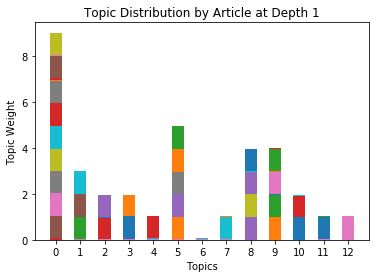

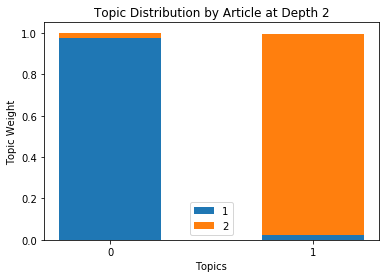

In [9]:
nca.stacked_barplot()

In [10]:
nca.topic_distribution()

************************************************************
max topic of doc 0 is: 10
max topic of doc 1 is: 9
max topic of doc 2 is: 9
max topic of doc 3 is: 10
max topic of doc 4 is: 8
max topic of doc 5 is: 0
max topic of doc 6 is: 0
max topic of doc 7 is: 0
max topic of doc 8 is: 0
max topic of doc 9 is: 0
max topic of doc 10 is: 11
max topic of doc 11 is: 5
max topic of doc 12 is: 1
max topic of doc 13 is: 0
max topic of doc 14 is: 5
max topic of doc 15 is: 1
max topic of doc 16 is: 9
max topic of doc 17 is: 0
max topic of doc 18 is: 8
max topic of doc 19 is: 7
max topic of doc 20 is: 3
max topic of doc 21 is: 3
max topic of doc 22 is: 9
max topic of doc 23 is: 2
max topic of doc 24 is: 8
max topic of doc 25 is: 0
max topic of doc 26 is: 12
max topic of doc 27 is: 5
max topic of doc 28 is: 0
max topic of doc 29 is: 1
max topic of doc 30 is: 8
max topic of doc 31 is: 5
max topic of doc 32 is: 5
max topic of doc 33 is: 4
max topic of doc 34 is: 2
***********************************

In [11]:
nca.print_topics()

************************************************************
Topic 0: *entrepreneur* *internet* *going* *chimerica* *investor* *go* *hit* *find* *party* *worry* *article* *growth* *stock* *viral* *higher* *online* *bank* *relationship* *ambiguity* *cut* *taking* *consumer* *wrote* *fundamentally* *author* *leader* *sell* *rule* *whether* *hard* *three* *willing* *chinese government* *hoping* *central* *raising* *hope* *tension* *china central* *analyst* *commentary* *face* *within* *economic growth* *night* *benefit* *reason* *wo* *wo nt* *generation*

Topic 1: *march* *fruit* *world economic* *earth* *growth* *long march* *mr xi* *transfer* *le* *property* *intellectual property* *compared year* *compared year earlier* *year earlier* *long* *according* *rare earth* *increase* *japan* *technology* *currency* *freedom* *xu* *new long march* *korean* *new long* *worldwide* *flow* *follow* *account* *source* *chinese company* *south* *oxford economics* *oxford* *ordinary* *used* *rare* *d

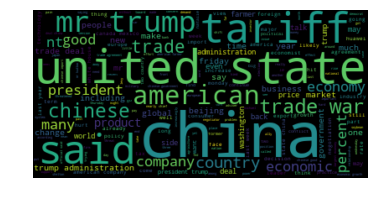

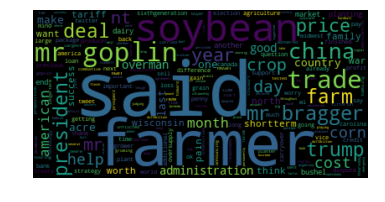

************************************************************


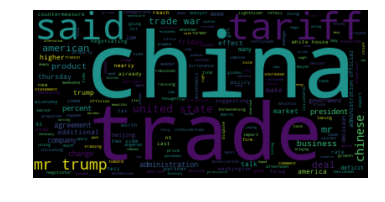

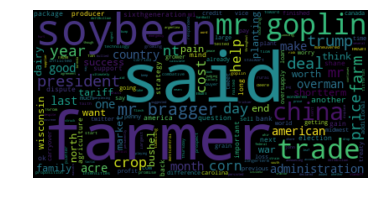

************************************************************


<Figure size 432x288 with 0 Axes>

In [12]:
nca.word_cloud()